<a href="https://colab.research.google.com/github/bingsen-wang/EE-Fundamentals/blob/main/MagneticCircuit_LinearSingleCoil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Linear Magnetic Circuit with Single Coil</h1></b>

Dr. Bingsen Wang

4/13/2024
</center>

#Python Code
The Python code illustrates the linear magnetic circuit.

<ipython-input-65-ff3d935a53ce>:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


0
0
60
120
180
240
300
360
420
0


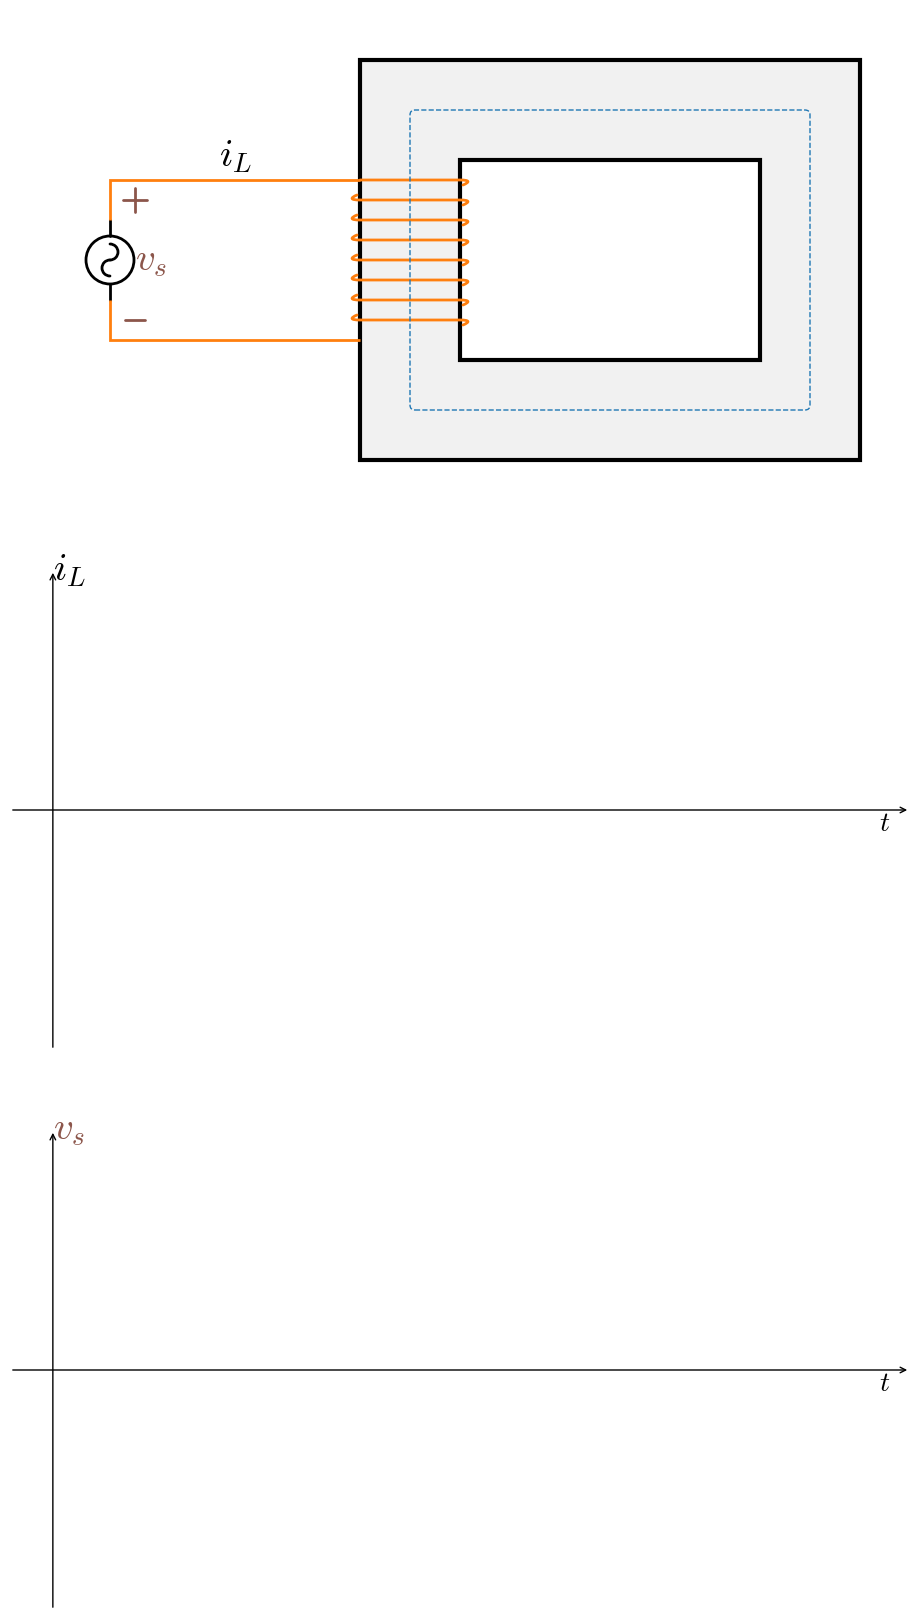

In [65]:
import matplotlib
from os import linesep
from math import ceil
import numpy as np
from numpy import linspace,cos,sin,pi,heaviside,array,sqrt,angle,exp,sign
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba#,TABLEAU_COLORS
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#modulation functions
def mf(t,f,phi):
  mta = cos(2*pi*f*t+phi)
  mtb = cos(2*pi*f*t+phi-2*pi/3)
  mtc = cos(2*pi*f*t+phi+2*pi/3)
  return [mta,mtb,mtc]

#switching functions for the high-side diodes
def hh(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+1)%3],0)*heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+2)%3],0))
  return ht

#switching functions for the low-side diodes
def hl(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+1)%3],0)*heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+2)%3],0))
  return ht

#ac current
def iac(t,f,phi):
  i = [] #high side current
  for k in range(3):
    i.append(hh(t,f,phi)[k] - hl(t,f,phi)[k])
  return i

#draw diode symbol
def drawDiode(ax,x0,y0,h,theta,lw,color):
  codes=[Path.MOVETO,Path.LINETO]
  p1=mp.PathPatch(Path([(x0,y0),(x0,y0+h*0.4), (x0,y0+h*0.6),(x0,y0+h)],
                       codes+codes))
  p2=mp.PathPatch(Path([(x0-h*0.1,y0+h*0.6),(x0+h*0.1,y0+h*0.6)],
                       codes)) #cathode
  p3=mp.PathPatch(Path([(x0,y0+h*0.6),(x0-h*0.1,y0+h*0.4),(x0+h*0.1,y0+h*0.4),(x0,y0+h*0.6)],
                       [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY])) #anode
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  kwargs=dict({'ec':color,'fc':['none','none',color],'lw':lw,'transform':rot})
  ax.add_collection(PatchCollection([p1,p2,p3],**kwargs))
  return

#draw coil
def drawCoil(ax,x0,y0,n,h,w,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  hpc = h/n #height per coil
  p = []
  codes=[Path.MOVETO,Path.LINETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  codes1=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4,Path.LINETO,
          Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0+w,y0),(x0+1.1*w,y0),(x0+1.1*w,y0-.1*hpc),(x0+w*1.03,y0-.25*hpc)]
  for k in range(n):
    if k==0:
      p.append(mp.PathPatch(Path(verts,codes)))
    else:
      verts=[(x0-.03*w,y0-k*hpc+.25*hpc),(x0-.1*w,y0-k*hpc+.1*hpc),(x0-.1*w,y0-k*hpc),
       (x0,y0-k*hpc),(x0+w,y0-k*hpc),
       (x0+1.1*w,y0-k*hpc),(x0+1.1*w,y0-k*hpc-.1*hpc),(x0+w*1.03,y0-k*hpc-.25*hpc)]
      p.append(mp.PathPatch(Path(verts,codes1)))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return


#draw flux lines inside the magnetic core
def drawFluxLines(ax,x0,y0,n,hi,ho,wi,wo,lw,color):
  dw = .5*(wo-wi)/(n+1)
  dh = .5*(ho-hi)/(n+1)
  for k in range(ceil(n)*2+1):
    w = .5*(wo+wi) - dw*(ceil(n)-k)
    h = .5*(ho+hi) - dh*(ceil(n)-k)
    fll = mp.FancyBboxPatch((x0-.5*w,y0-.5*h), w, h, ls='--', lw=lw,
        boxstyle='Round, pad=0, rounding_size=0.05', ec=color,fc='none')
    ax.add_patch(fll)
  return

#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[]
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#moving dots for current flow, only works for any lines
def drawMovingDots(ax,path,space,n_steps,nth_step,rdot,color):
  for k in range(len(path)-1):
    pk = path[k][0] +1j*path[k][1] #complex number of point k
    pk1 = path[k+1][0] +1j*path[k+1][1] #complex number of point k+1
    dp = pk1-pk
    theta = angle(dp)
    if k==0:
      lst = space*nth_step/n_steps# distance of starting point
    for kk in range(int((abs(dp)-lst)/space)+1):
      ax.add_patch(mp.Circle([(pk+(lst+kk*space)*exp(1j*theta)).real,
       (pk+(lst+kk*space)*exp(1j*theta)).imag],radius=rdot,fc=color))
    lst = space - (abs(dp)-lst)%space #update the distance of starting point
  return

#draw non-animated parts of the circuitry
def drawCircuitNa(ax,lw,clst,txlst):
  x0,y0,wo,ho,wi,hi = 6,2.5,5,4,3,2
  reco = mp.Rectangle(xy=(x0-.5*wo,y0-.5*ho),
                      width=wo,height=ho,ec='k',fc=to_rgba('lightgray',.3),lw=3) #outer rect
  reci = mp.Rectangle(xy=(x0-.5*wi,y0-.5*hi),
                      width=wi,height=hi,ec='k',fc='w',lw=3) #outer rect
  ax.add_patch(reco)
  ax.add_patch(reci)
  drawCoil(ax,x0-.5*wo,y0+.8,8,1.6,.5*(wo-wi),0,lw,'tab:orange')
  drawVoltSourceAc(ax,x0-5,y0-.4,.8,90,lw,'k')
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO]
  p = Path([(x0-5,y0+.4),(x0-5,y0+.8),(x0-.5*wo,y0+.8)], codes)
  ax.add_patch(mp.PathPatch(p,ec='tab:orange',fc='none',lw=lw))
  p = Path([(x0-5,y0-.4),(x0-5,y0-.8),(x0-.5*wo,y0-.8)], codes)
  ax.add_patch(mp.PathPatch(p,ec='tab:orange',fc='none',lw=lw))
  ax.text(x0-3.75,y0+.85,txlst[0][0],size=28,color=clst[0],va='bottom',ha='center')
  ax.text(x0-4.75,y0,txlst[1][0],size=28,color=clst[1],va='center',ha='left')
  return

#draw animated parts of the circuitry
def drawCircuitAnim(ax,i_ani,ist,vst,lw,clst):
  x0,y0,wo,ho,wi,hi = 6,2.5,5,4,3,2
  nmax = 7 #max number of flux lines 2*nmax+1
  drawVoltSign(ax,x0-4.75,y0, 1.2*vst,-90,2,clst[1]) #vs sign

  points =[]
  points.append([(x0-5,y0+.4),(x0-5,y0+.8),(x0-.5*wi,y0+.8)])
  points.append([(x0-.5*wo,y0-.8),(x0-5,y0-.8),(x0-5,y0-.4)])
  for k in range(7):
    points.append([(x0-.5*wo,y0+.6-k*.2),(x0-.5*wi,y0+.6-k*.2)])

  if ist>0:
    drawFluxLines(ax,x0,y0,nmax*ist,hi,ho,wi,wo,1,'tab:red')
    for k in range(len(points)):
      drawMovingDots(ax,points[k],0.25,16,i_ani%16,.05*sqrt(ist),clst[0])
  else:
    drawFluxLines(ax,x0,y0,nmax*abs(ist),hi,ho,wi,wo,1,'tab:blue')
    for k in range(len(points)):
      drawMovingDots(ax,points[k][::-1],0.25,16,i_ani%16,.05*sqrt(-ist),clst[0])
  return

#parameters
f=1
Nf = 480
t=linspace(0,1,Nf)
ist = sin(2*pi*f*t)
vst = cos(2*pi*f*t)

#set up figures
fig = plt.figure(figsize=(9,16)) #landscape aspect ratio for desktop
km = 1.1 # margin
ax_frame = [[(0, 11/16, 1, 5/16), [0,9], [0,5]], #non-animated circuit
            [(0, 11/16, 1, 5/16), [0,9], [0,5]], #animated circuit
            [(0, .35, 1, .3),[-.05*km,1*km],[-km,km]], #v
            [(0, 0, 1, .3),[-.05*km,1*km],[-km,km]], #i
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lst=[] #axis list or the list of subplots
ax_lbl=[['$i_{L}$', '$t$'],
        ['$v_{s}$', '$t$'],
        ] #variables for yx axes of each subplot
clst=['k','tab:brown','tab:orange'] #list of colors

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
for k in range(len(ax_frame)):
  xmin,xmax,ymin,ymax=ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=(xmin,xmax), ylim=(ymin,ymax),fc='none')
  ax.axis('off')
  if k>1:
    ap=dict(arrowstyle="->")
    ax.annotate("", xy=(xmax,0), xytext=(xmin,0), arrowprops=ap) #x-axis
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin), arrowprops=ap) #y-axis
    ax.text(xmax-.025,0,ax_lbl[k-2][-1], size=20,va='top',ha='right',color='k')
    ax.text(0,ymax,ax_lbl[k-2][0],size=28,va='center',color=clst[k-2])
    lines.append(ax.plot([],[],color=clst[k-2],lw=4)[0])
  ax_lst.append(ax)
fig.tight_layout()

# animation function. This is called sequentially
def animate(i):
  if i%60==0:
    print(i) #for monitoring progress
  lines[0].set_data(t[0:i],ist[0:i])
  lines[1].set_data(t[0:i],vst[0:i])
  ax_lst[1].clear()
  ax_lst[1].set_xlim(ax_frame[1][1])
  ax_lst[1].set_ylim(ax_frame[1][2])
  ax_lst[1].axis('off')
  drawCircuitAnim(ax_lst[1],i,ist[i],vst[i],1.5,clst)
  return

drawCircuitNa(ax_lst[0],2,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
writervideo = animation.FFMpegWriter(fps=30)
anim.save('MagneticCircuit_LinearSingleCoil.mp4', writer=writervideo,dpi = 120)

